## Three-dimensional realistic random model 
Developer:<br>
Mohammad Matin Bagheri<br>
e-mail:<br>
mm.bagheri@che.sharif.edu<br>


This program is aimed to simulate flow through pore network to calculate pressure gradient, flow and permeability of the network; the formulation also allows the user to simulate gas flow in the network by changing function "mass" which is dedicated to mass flux through the network.<br>

Some of the advantages and strengths of this program are:<br>
1. applicable for various sizes of the network [n * m * w]
2. realistic network model with maximum possible coordination number of z = 26
3. generates a schematic of the network to understand the continuity and adjacency of the points
4. employing 2 different solution methods in the case of a singular matrix of coefficients
5. enabling various types of flow conditions through mass flux function: mass(r, l, z, P_avg, mu)
6. provide a colormap of pressure as well as a pressure gradient curve for a better understanding of the network 


In [1]:
""" Import Libraries """
import math
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
import networkx as nx

In [2]:
""" Input variable """

n = int(input('Please enter the number of vertical nodes, n = '))
m = int(input('Please ienter the number of horizontal nodes, m = '))
w = int(input('Please ienter the number of depth nodes, w = '))
Z_avg = float(input('Please enter the average coordination number, Z_avg = '))
cutoff = 1-Z_avg/26

R_avg = float(input('Please enter the average pore size in microns [micron], R_avg = '))
R_stdv = float(input('Please enter the pore size standard diviation in microns [micron], R_stdv = '))

L_avg = float(input('Please enter the average throat length in microns [micron], L_avg = '))
L_stdv = float(input('Please enter the throat length standard diviation in microns [micron], L_stdv = '))

T = float(input('Please enter the average temperature of the system [C], T = '))
T += 273.15
Mw = float(input('Please enter the molecular weight of the fluid in [g/mol], Mw = '))
Mw = Mw / 1000  #[kg/mol]


In [3]:
""" Boundary conditions """

P1 = float(input('Please enter the inflow pressure [pa], P1 = '))
P2 = float(input('Please enter the outflow pressure [pa], P2 = '))
T0 = float(input('Please enter the average temperature of the system [C], T0 = '))
M = float(input('Please enter the molar mass of the gas [g/mol], M = '))
mu = float(input('Please enter average viscosity of the gas [Pa.s], mu = '))

Grid = np.ones((n, m, w)) * P1

for j in range(m):
  for k in range(w):
    Grid[0, j, k] = P1
    Grid[n-1, j, k] = P2


In [4]:
""" Trhoats radius, length and coordination number """

R = np.random.normal(R_avg, R_stdv, (3, 3, 3, n * m * w))
L = np.random.normal(L_avg, L_stdv, (3, 3, 3, n * m * w))
Z = np.random.uniform(0, 1, (3, 3, 3, n * m * w))

In [5]:
""" Transportation functions """


def valid(i, j, k, n , m, w):   # checks the validity of a point
  return ((i>=0) and (j>=0) and (k>=0) and (i<=n-1) and (j<=m-1) and (k<=w-1))


def transform(i, j, k, n, m, w):  # gives the index of a given point (i, j) in an equivalent 1-D array
  index = i * (m * w) + j * w + k
  return index

def anti_transform(x, m, w):  # Is the reverse of trasnform function
  k = int(x % w)
  x = (x-k)/w
  j = int(x % m)
  x = (x-j)/m
  i = int(x)
  return i, j, k

def Aij(i, j, k, x, y, z, n, m, w):  # Finds the position in matrix of coefficients for given point (x, y) in equation for point (i, j)
  Ai = transform(i, j, k, n, m, w) 
  Aj = transform(x, y, z, n, m, w) 
  return Ai, Aj

def dir(i, j, k, x, y, z):  # Gives a number between 0 to 26 for each two points
  dir_x = abs(x - i) + 1
  dir_y = abs(y - j) + 1
  dir_z = abs(z - k) + 1

  point1 = transform(i, j, k, n, m, w)
  point2 = transform(x, y, z, n, m, w)
  return dir_x, dir_y, dir_z, max(point1, point2)

def riverse_dir(x, y, z):
  i = 2 - x
  j = 2 - y
  k = 2 - z
  return x, y, z

def mass(r, l, z, P_avg, mu):  # Calculates the mass relative flow rate in a throat
  R_const = 8.314
  m_HP = math.pi * pow(r,4) / (8 * mu * l) #* P_avg /(R_const * T)  # =====> use this section for gas flow
  m_K = (2 * math.pi * pow(r, 3)/3) * math.sqrt(8 / (Mw * math.pi * R_const * T)) # =====> must add this parameter in case of gass flow
  return (m_HP) * (z > cutoff)


In [6]:
""" SOR solver function """

def sor_solver(A, b, omega, initial_guess, convergence_criteria):
    """
    This is an implementation of the pseudo-code provided in the Wikipedia article.
    Arguments:
        A: nxn numpy matrix.
        b: n dimensional numpy vector.
        omega: relaxation factor.
        initial_guess: An initial solution guess for the solver to start with.
        convergence_criteria: The maximum discrepancy acceptable to regard the current solution as fitting.
    Returns:
        phi: solution vector of dimension n.
    """
    step = 0
    phi = initial_guess[:]
    max_steps = 100
    residual = np.linalg.norm(np.matmul(A, phi) - b)  # Initial residual
    while residual > convergence_criteria and step < max_steps:
        for i in range(A.shape[0]):
            sigma = 0
            for j in range(A.shape[1]):
                if j != i:
                    sigma += A[i, j] * phi[j]
            phi[i] = (1 - omega) * phi[i] + (omega / A[i, i]) * (b[i] - sigma)
        residual = np.linalg.norm(np.matmul(A, phi) - b)
        step += 1
        print("Step {} Residual: {:10.6g}".format(step, residual))
    return phi


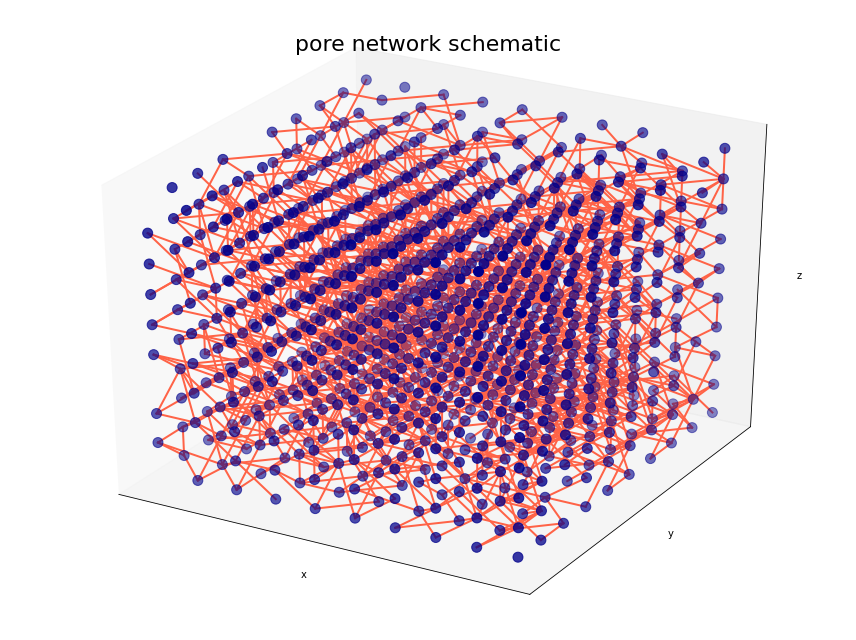

In [7]:
""" Pore network schematic """
G = nx.Graph(dim = 3)

for i in range(n):
    for j in range(m):
      for k in range(w):

        for x_prime in [0, 1, -1]:
          for y_prime in [0, 1, -1]:
            for z_prime in [0, 1, -1]:

              x = i + x_prime
              y = j + y_prime
              z = k + z_prime

              if valid(x, y, z, n, m, w) == True and Z[dir(i, j, k, x, y, z)] > cutoff:
                nx.add_path(G, [(i, j, k), (x, y, z)])


""" Drawing the geometric graph """
# Extract node and edge positions from the layout
node_xyz = np.array([v for v in sorted(G)])
edge_xyz = np.array([(u, v) for u, v in G.edges()])

# Create the 3D figure
fig = plt.figure(figsize = (12, 9))
ax = fig.add_subplot(111, projection="3d")

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=100, color = 'darkblue')

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tomato", linewidth = 2.0)


def _format_axes(ax):
    """Visualization options for the 3D axes."""
    # Turn gridlines off
    ax.grid(False)
    # Suppress tick labels
    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([])
    # Set axes labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_title('pore network schematic', fontsize=22)


_format_axes(ax)
fig.tight_layout()
plt.show()

In [8]:
""" System of equations """

# matrix of coefficients
A = np.zeros((n*m*w, n*m*w))
A = np.asmatrix(A)

for j in range(m):  # for the boundary cells
  for k in range(w):
    A[Aij(0, j, k, 0, j, k, n, m, w)] = 1
    A[Aij(n-1, j, k, n-1, j, k, n, m, w)] = 1

sum_error = 10
tolerance = 1 
iteration = 0

while (sum_error > tolerance) and (iteration < 20):
  iteration = iteration + 1

  for i in range(1, n-1):
    for j in range(m):
      for k in range(w):
        sum_coeff = 0
        for x_prime in [0, 1, -1]:
          for y_prime in [0, 1, -1]:
            for z_prime in [0, 1, -1]:

              x = i + x_prime
              y = j + y_prime
              z = k + z_prime
              distance = math.sqrt(x_prime**2 + y_prime**2 + z_prime**2)

              if (i, j, k) != (x, y, z):
                if valid(x, y, z, n, m, w): # for the cells inside the main grid

                  r = R[dir(i, j, k, x, y, z)]
                  l = distance * L[dir(i, j, k, x, y, z)]
                  zr = Z[dir(i, j, k, x, y, z)]
                  P_avg = (Grid[i, j, k] + Grid[x, y, z]) / 2
                  A[Aij(i, j, k, x, y, z, n, m, w)] = -mass(r, l, zr, P_avg, mu)

                # Periodic conditions for boundaries
                else:
                  y = (m-1) * (y == -1)
                  z = (w-1) * (z == -1)
                  r = R_avg
                  l = L_avg
                  zr = 1
                  P_avg = (Grid[i, j, k] + Grid[x, y, z]) / 2
                  A[Aij(i, j, k, x, y, z, n, m, w)] = -mass(r, l, zr, P_avg, mu)

        A[Aij(i, j, k, i, j, k, n, m, w)] = 0

  for i in range(len(A)):
    if (anti_transform(i, m, w)[0] not in [0, n-1]): 
      A[i, i] = - np.sum(A[i])

  # The vector of answers

  b = np.zeros((n, m, w))
  for j in range(m):
    for k in range(w):
      b[0, j, k] = P1
      b[n-1, j, k] = P2

  b = b.reshape(n*m*w)
  b = b.transpose()

  # elimination of random "0" rows

  all_zeros = []
  counter = 0
  for i in range(len(A)):
    if np.all((A[i] == 0)):
      all_zeros.append(i)
      A[i, i] = 1
      b[i] = 0
      counter = counter + 1

  # Solving the Ax = b equation
  
  try:
    P = np.linalg.solve(A, b)
  except:
    P = sor_solver(A, b, 1.5, Grid.reshape(n*m*w), tolerance)

    #for i in all_zeros:
      #P = np.insert(P, i, 0, axis = 0)
  Grid_prime = P.reshape(n, m, w)
  sum_error = np.sum(abs(Grid - Grid_prime)) / np.sum(Grid)

  Grid = P.reshape(n, m, w)

In [9]:
""" Calculating premeability """

Q = []
for j in range(m):
  for k in range(w):
    x_prime = 1
    for y_prime in [0, 1, -1]:
      for z_prime in [0, 1, -1]:

        x = n-2
        y = j + y_prime
        z = k + z_prime
        distance = math.sqrt(x_prime**2 + y_prime**2 + z_prime**2)

        if valid(x, y, z, n, m, w):

          r = R[dir(n-1, j, k, x, y, z)]
          l = distance * L[dir(n-1, j, k, x, y, z)]
          zr = Z[dir(n-1, j, k, x, y, z)]
          Q.append(math.pi*(Grid[x, y, z]-Grid[n-1, j, k])*pow(r, 4)/(8 * mu * l) * (zr > cutoff))

Q = np.nansum(Q)
Area = (2 * m * R_avg + L_avg * (m-1)) * (L_avg * (w-1) + R_avg * w * 2) # A [micron^2]
L = L_avg * (n-1) + R_avg * n * 2 # L [micron]
K = Q * L * mu / (Area * (P1 - P2))  # k [darcy]

print('The flow rate Q = ' + str(Q*1e-18) + '[m^3/s]')
print('The permeability K = ' + str(K * 1.01325E+3) + ' [md]')

The flow rate Q = 6.322688100411565e-10[m^3/s]
The permeability K = 291.20289626100083 [md]


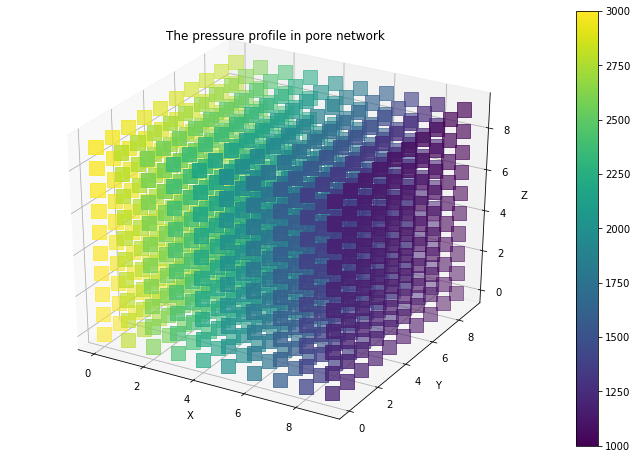

In [10]:
""" plotting """
grid = Grid.nonzero()
x, y, z = grid
t = np.zeros(n*m*w)
for i in range(n):
  for j in range(m):
    for k in range(w):
      if Grid[i, j, k] != 0:
        t[transform(i, j, k, n, m, w)] = Grid[i, j, k]

# creating figures
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# setting color bar
color_map = cm.ScalarMappable(cmap=cm.viridis)
color_map.set_array(Grid[Grid != 0].reshape(-1))

# creating the heatmap
t = t.nonzero()
img = ax.scatter(x, y, z, marker='s', s=200, cmap='viridis_r', c=t)
plt.colorbar(color_map)

# adding title and labels
ax.set_title("The pressure profile in pore network")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
  
# displaying plot
plt.show()

Text(0, 0.5, 'Pressure [Pa]')

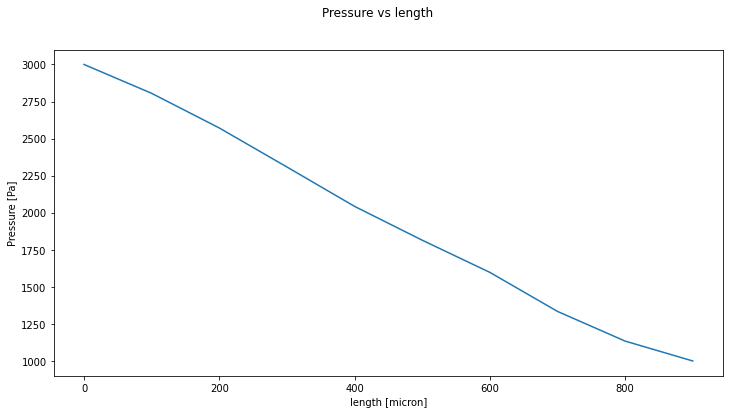

In [11]:
""" 2-D plot """
P_x = np.zeros(n)
for i in range(n):
  P_x[i] = np.mean(Grid[i, :, :])

# plotting
fig = plt.figure(figsize = (12, 6))
x = np.arange(n) * L_avg
plt.plot(x, P_x)
fig.suptitle('Pressure vs length')
plt.xlabel('length [micron]')
plt.ylabel('Pressure [Pa]')